#  Fitting Spectrum

This notebook shows the aplication of fitting code to a 5-component spectrum 


In [1]:
import matplotlib.pylab as plt
import scipy.optimize as sop
import tables as tb
import pandas as pd
from Histogram import Histogram as hist
from PDF import PDF
import numpy as np
from Fits import Fit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 16, 12
plt.rcParams["font.size"]               = 15
#plt.rcParams["figure.max_open_warning"] = 100

In [3]:
regions = ['Anode', 'Barrel', 'Cathode']
isotopes = ['K', 'Co', 'Bi', 'Tl']
nbinE = 150
minE, maxE = 650, 2700
nbinZ = 100
minZ, maxZ = 10, 550

In [4]:
def SigmaEstimator(E, rlim = 0.01):
    #res en Q_bb
    qbb = 2458     #MeV

    return rlim*(qbb*E)**0.5/2.35482

def Gaussianizator(E,sigma = -1, rlim = 0.01):
    if sigma<0:
        sigma = SigmaEstimator(E, rlim)
    return E #np.random.normal(E, sigma)


def h_Gauss(h,sigma = -1, rlim = 0.01):
    nbin = h.nbin
    minE = h.minlim
    maxE = h.maxlim
    hnew = hist([],nbin,minE,maxE)
    hnew.hist = np.zeros_like(h.hist)
    hnew.bins = h.bins[:]

    for i in range(nbin):
        Caux = h.bins[i]
        naux = h.hist[i]
        for j in range(int(naux)):
            hnew.Fill_hist(Gaussianizator(Caux, sigma, rlim))
    return hnew

# Reading and building MC PDFs

In [5]:
mc_pdfs = {}

In [6]:
with tb.open_file("../Data/new_MC_innercastle_Topology_pdfs/pdf_fid_hits_MC_bkg_innercastle.h5", "r") as f_pdfs:
    for region in regions:
        mc_pdfs[region] = {}
        for isotope in isotopes:
            group = getattr(f_pdfs.root, region)
            node  = getattr(group, isotope)
            mc_pdfs[region][isotope] = pd.DataFrame.from_records(node.read())

In [7]:
mc_pdfs[region][isotope].columns

Index(['index', 'evt_energy', 'numb_of_tracks', 'energy', 'length',
       'numb_of_voxels', 'eblob1_bary', 'eblob2_bary', 'ovlp_energy', 'nS2',
       'Xavg', 'Yavg', 'Zavg', 'minZ', 'maxZ', 'maxR', 'event', 'x_blob_1',
       'y_blob_1', 'z_blob_1', 'x_blob_2', 'y_blob_2', 'z_blob_2', 'subindex',
       'dist_blobs', 'evt_number', 'atomic_number', 'mass_number', 'region',
       'isotope'],
      dtype='object')

In [8]:
#as just energy is required, all regions are joined

In [9]:
histograms = {'E':[], 'z':[]}
name       = []
N_MC       = []


for isotope in isotopes:
    df = []
    name.append(isotope) 
    for region in regions:
        
        df.append(mc_pdfs[region][isotope])
    df = pd.concat(df)       
    histograms['E'].append(hist(df.energy , nbinE, minE, maxE))
    histograms['z'].append(hist(df.Zavg                            , nbinZ, minZ, maxZ))                      
    N_MC           .append(len(df.evt_energy.unique()))




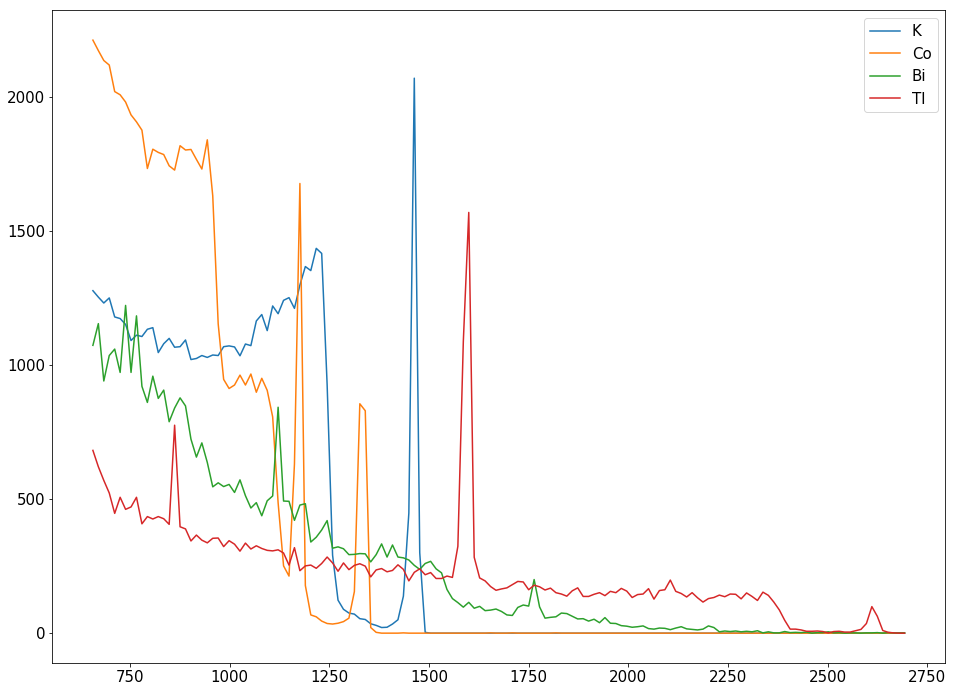

In [10]:
i = 0
for isotope in isotopes:
    h_ = histograms['E'][i]
    plt.plot(h_.bins, h_.hist, label=name[i])
    i += 1
    plt.legend()

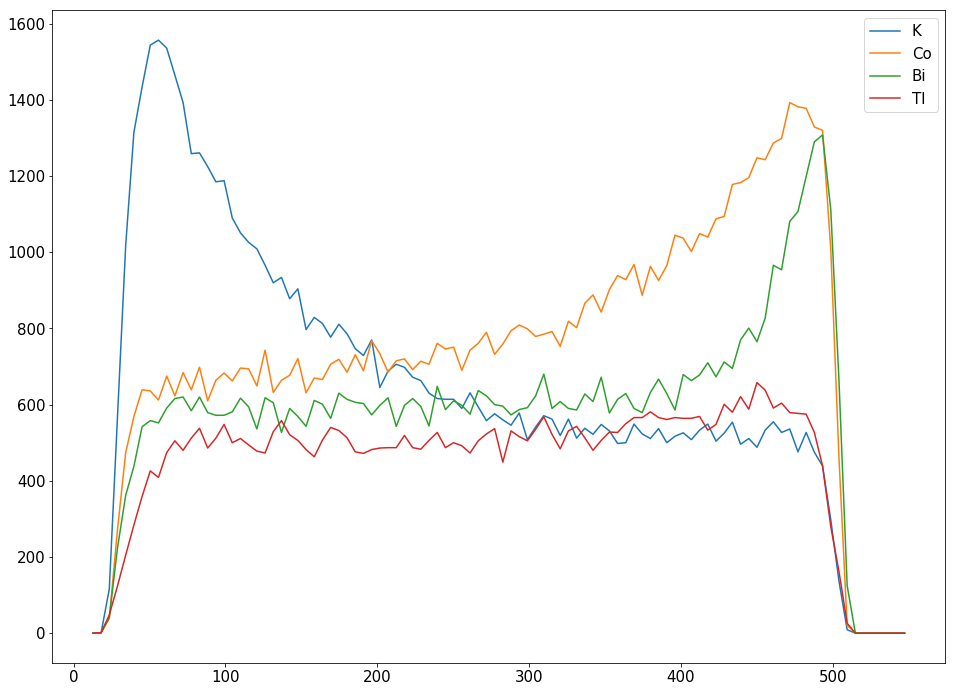

In [11]:
i = 0

for isotope in isotopes:
    h_ = histograms['z'][i]
    plt.plot(h_.bins, h_.hist, label=name[i])
    i += 1
plt.legend()

In [66]:
pdfs = {'E':[]}#, 'z':[]}

interpol = 'cubic'

pdfs['E'] = [PDF(h_, interpolation=interpol) for h_ in histograms['E']]
#pdfs['z'] = [PDF(h_, interpolation=interpol) for h_ in histograms['z']]

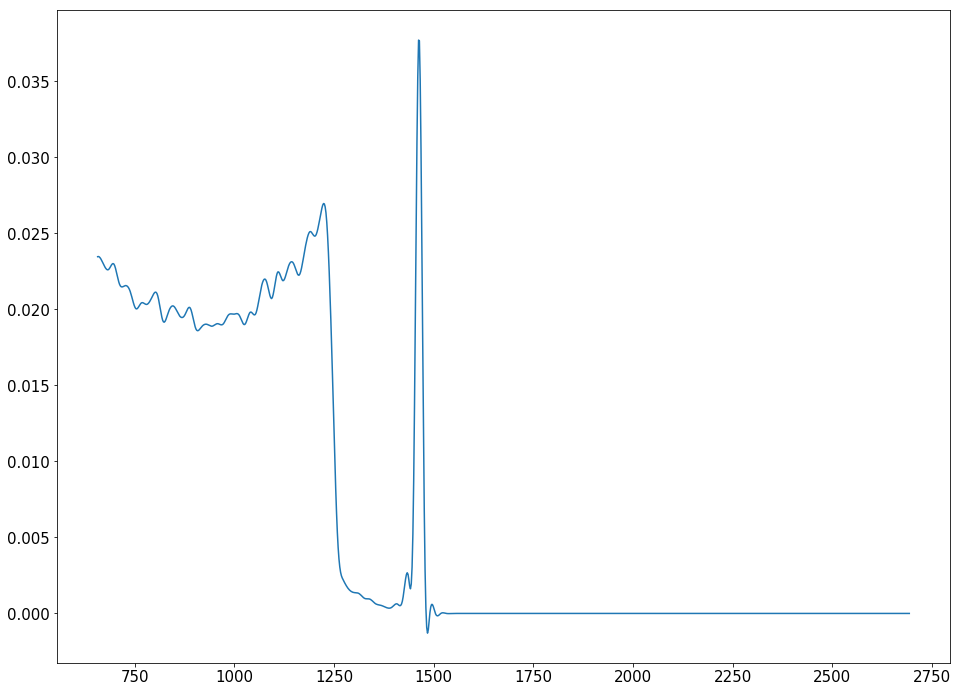

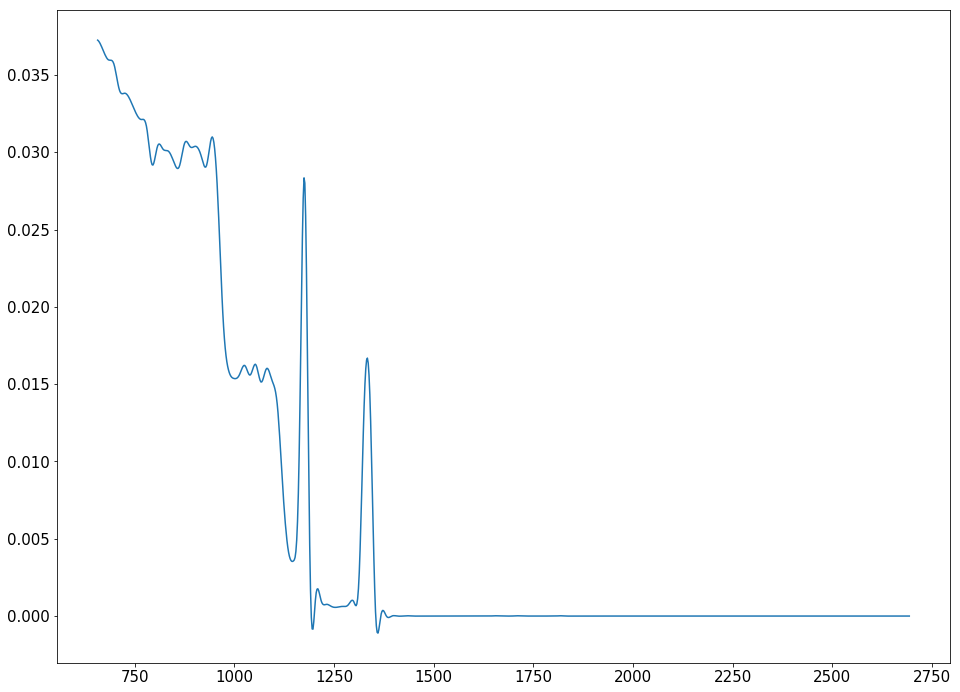

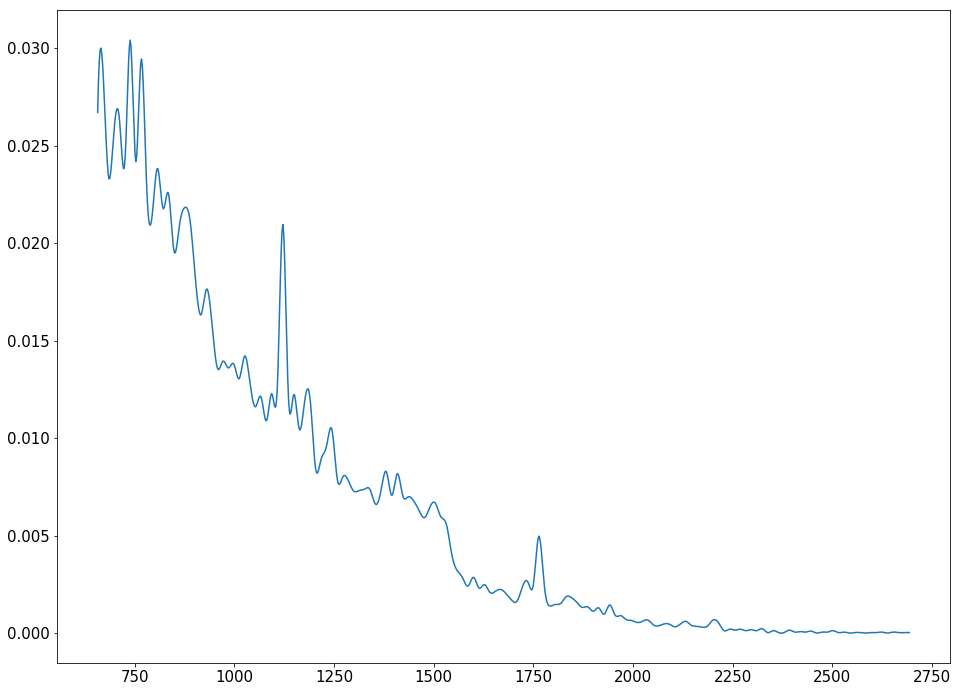

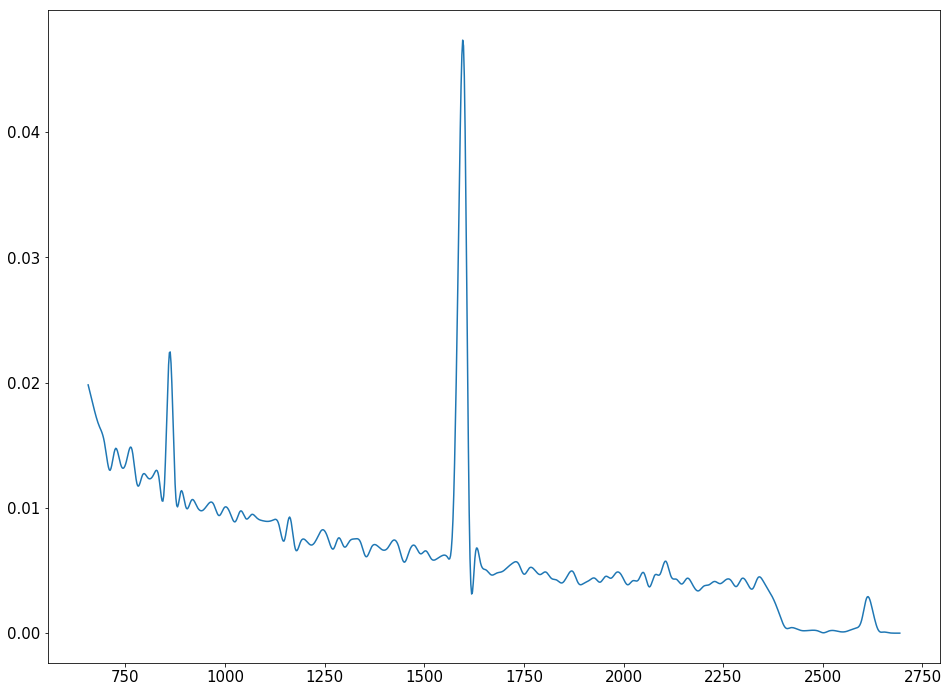

In [67]:
Ep = np.linspace(histograms['E'][0].bins[0],histograms['E'][0].bins[-1],1000)

for pdf in pdfs['E']:
    
    plt.figure()
    y = pdf.pdf(Ep)
    plt.plot(Ep, y)
    plt.show()

In [68]:
x_dict = {'E': histograms['E'][0].bins }#, 'z': histograms['z'][0].bins}

# "MC-Data reading"

## Bkg

In [69]:
f_data_b     = tb.open_file("../Data//new_MC_innercastle_Topology/topology_hits_MC_bkg_innercastle_energy_cut.hdf5", "r")
table_data_b = pd.DataFrame.from_records(f_data_b.root.dataframe.table.read())
table_data_b.head()

h_total_e_b = hist(table_data_b.energy, nbinE, minE, maxE)
h_total_z_b = hist(table_data_b.Zavg  , nbinZ, minZ, maxZ)

totals = {'E': h_total_e_b}#    , 'z': h_total_z_b  }

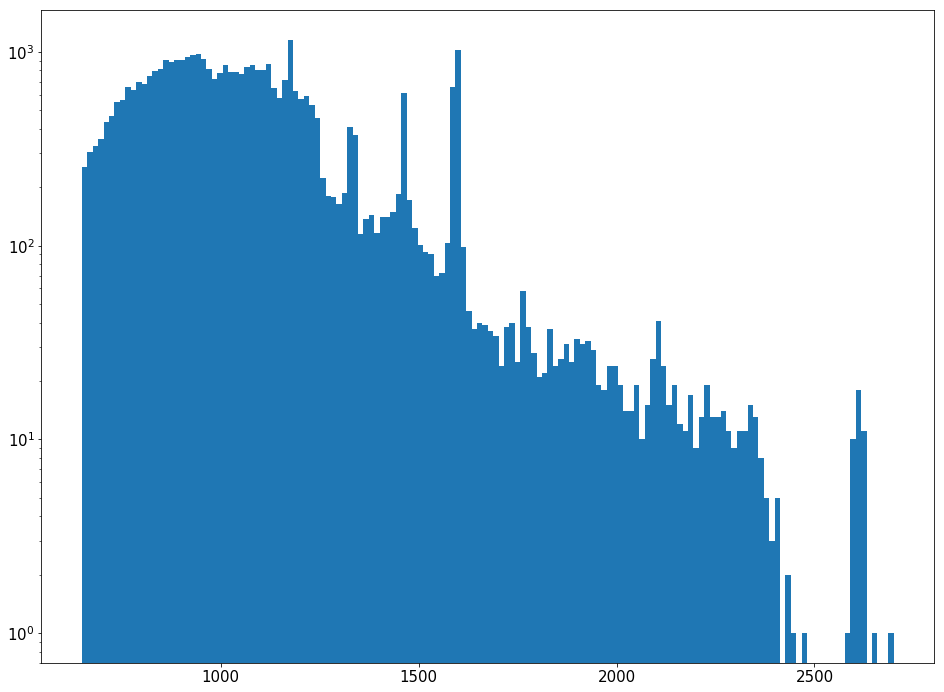

In [70]:
plt.hist(table_data_b.energy,nbinE,[minE,maxE]);
plt.yscale('log')

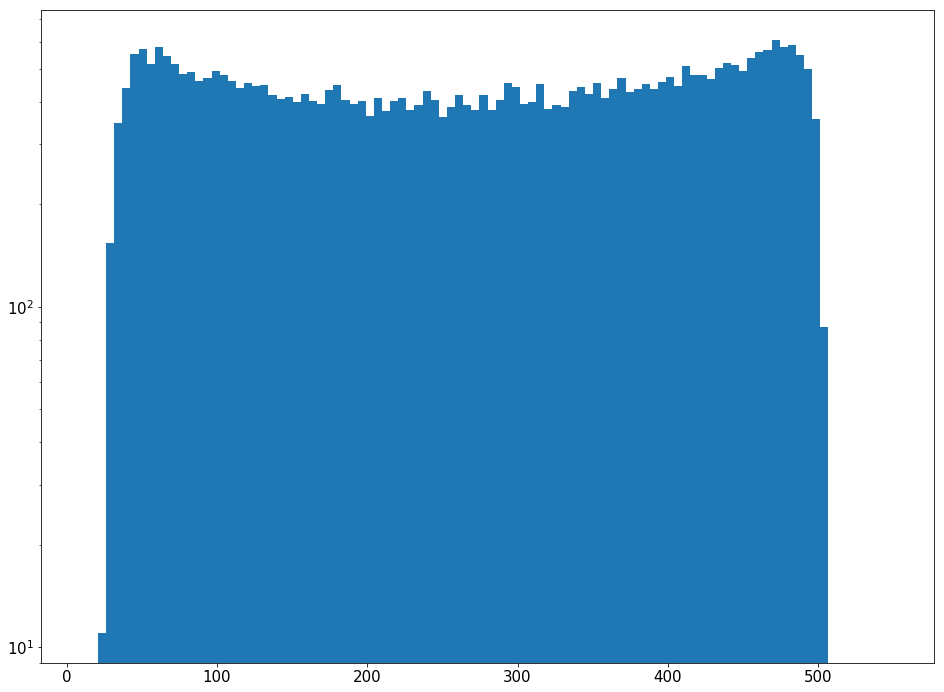

In [71]:
plt.hist(table_data_b.Zavg,nbinZ,[minZ,maxZ]);
plt.yscale('log')

## Signal

In [72]:
f_data_s     = tb.open_file("../Data/new_MC_innercastle_Topology/fid_hits_MC_xe2nu.hdf5", "r")
table_data_s = pd.DataFrame.from_records(f_data_s.root.dataframe.table.read())
table_data_s.head()

h_total_e_s = hist(table_data_s.energy, nbinE, minE, maxE)
h_total_z_s = hist(table_data_s.Zavg  , nbinZ, minZ, maxZ)

totals_s = {'E': h_total_e_s}#, 'z': h_total_z_s   }

#add signal pdf

interpol = 'cubic'

pdfs['E'] += [PDF(h_total_e_s, interpolation=interpol)]
#pdfs['z'] += [PDF(h_total_z_s, interpolation=interpol)]

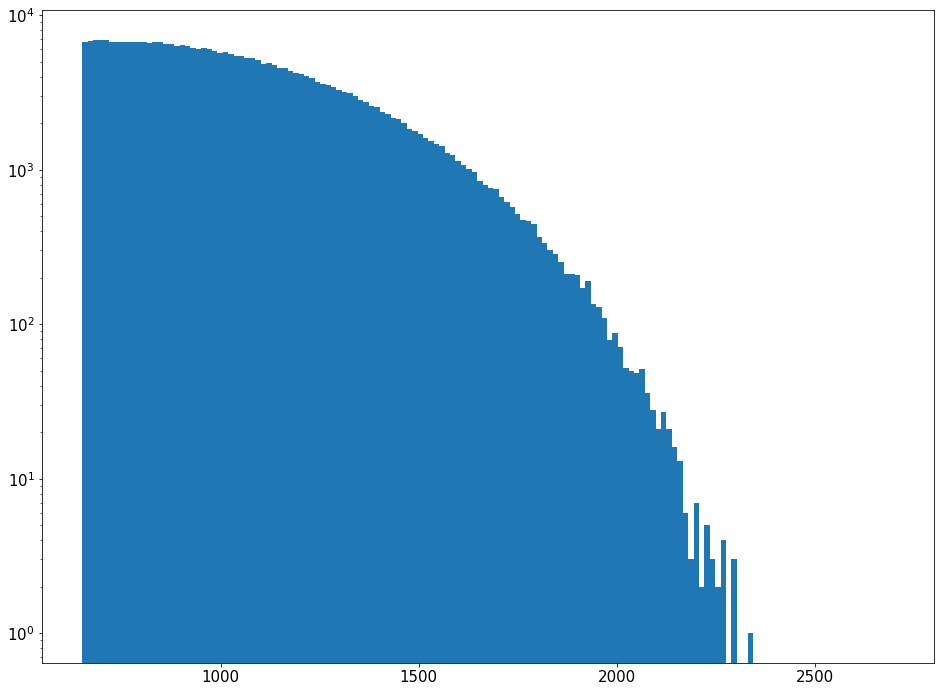

In [73]:
plt.hist(table_data_s.energy,nbinE,[minE,maxE]);
plt.yscale('log')

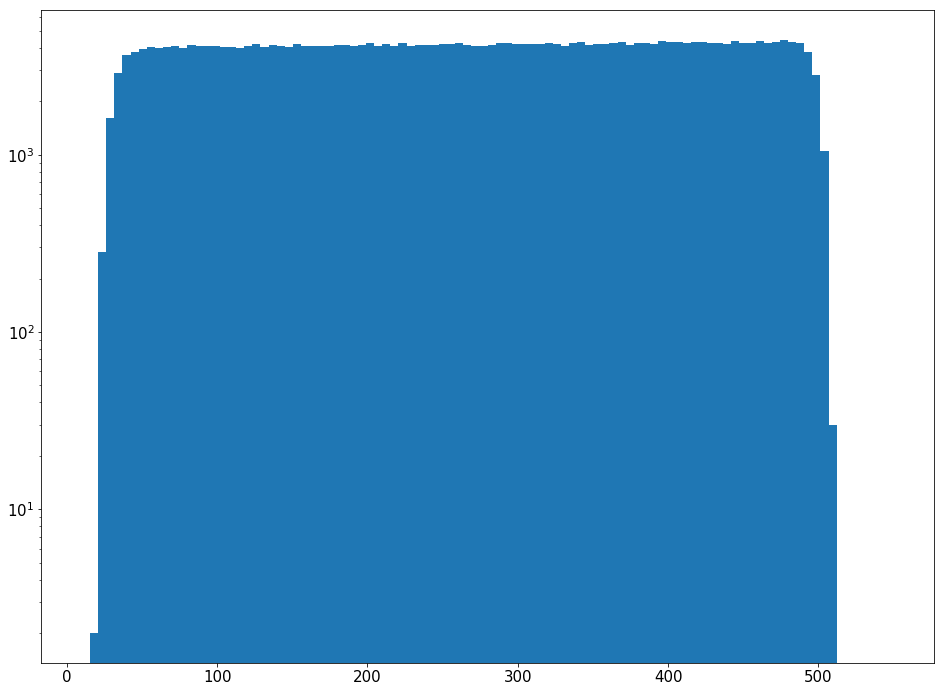

In [74]:
plt.hist(table_data_s.Zavg,nbinZ,[minZ,maxZ]);
plt.yscale('log')

# Exposure issues

In [75]:
#Pau normalization:
n_pau       = {} 
n_pau['K']  = 0.36
n_pau['Co'] = 4.38
n_pau['Bi'] = 1.69
n_pau['Tl'] = 1.55

In [76]:
expo_bb = 223.970 #y
expo_bkg  = 5.48    #y

In [77]:
N_K  = np.sum([len(mc_pdfs[region]['K'])  for region in regions])
N_Co = np.sum([len(mc_pdfs[region]['Co']) for region in regions])
N_Bi = np.sum([len(mc_pdfs[region]['Bi']) for region in regions])
N_Tl = np.sum([len(mc_pdfs[region]['Tl']) for region in regions])
N_bb = len(table_data_s)

# Fitting

In [78]:
#As we don't care abour regions, data are considered just by isotope
mc_pdfs_noreg = {}

for isotope in isotopes:
    mc_pdfs_noreg[isotope] = pd.concat([mc_pdfs[region][isotope] for region in regions]) 


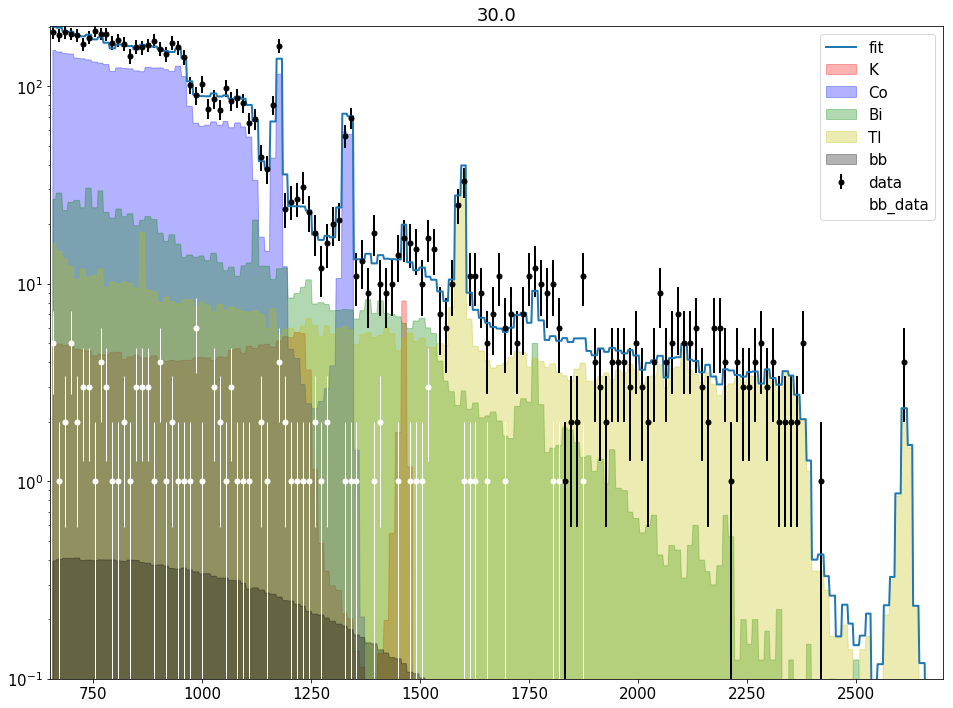

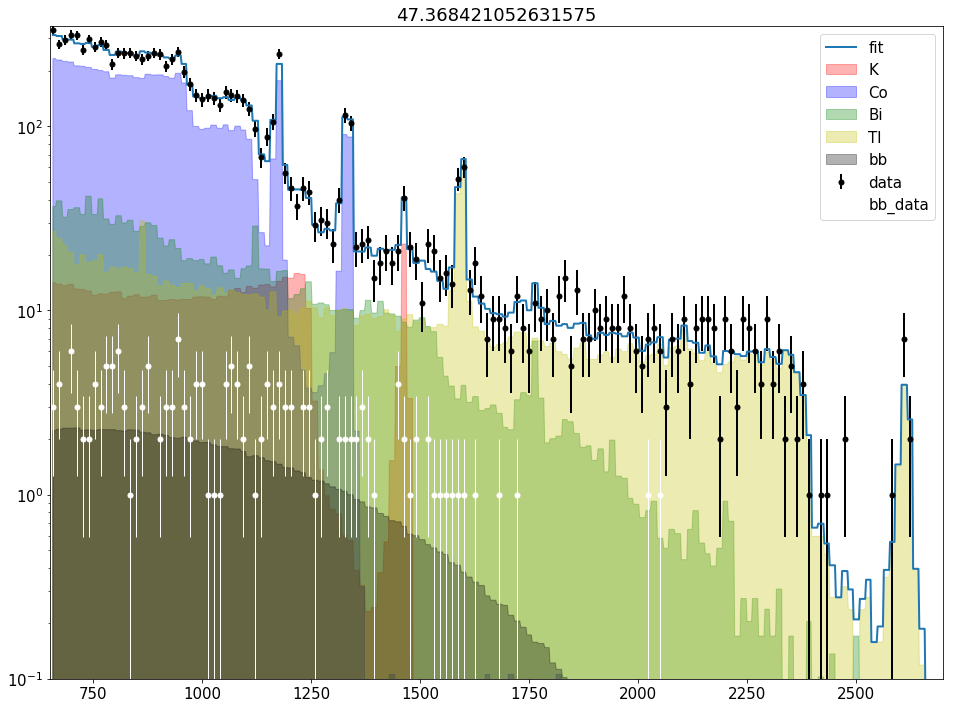

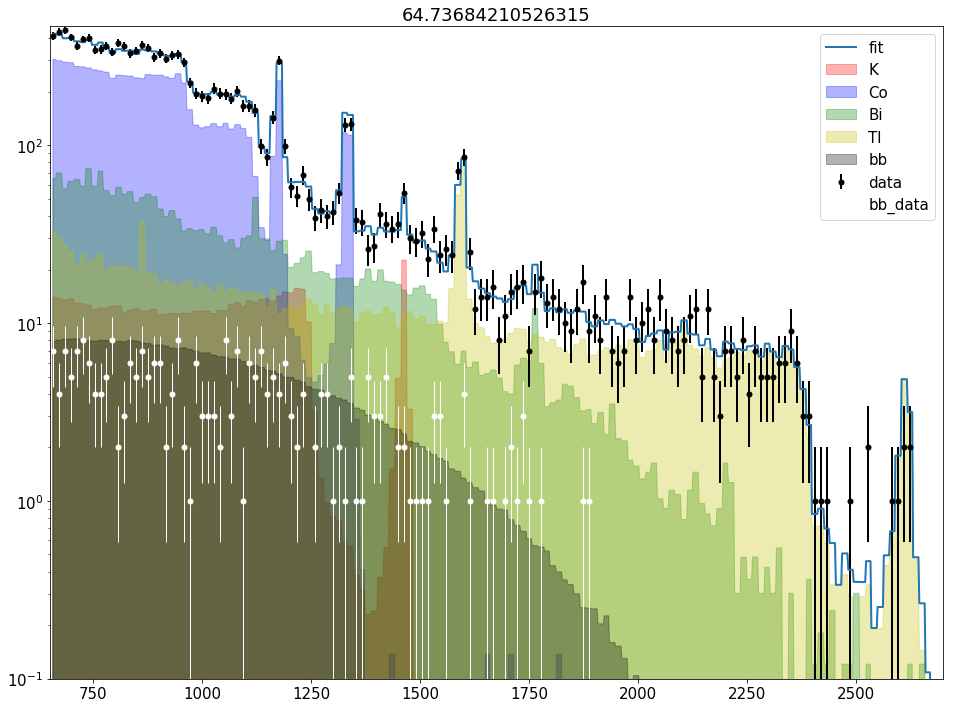

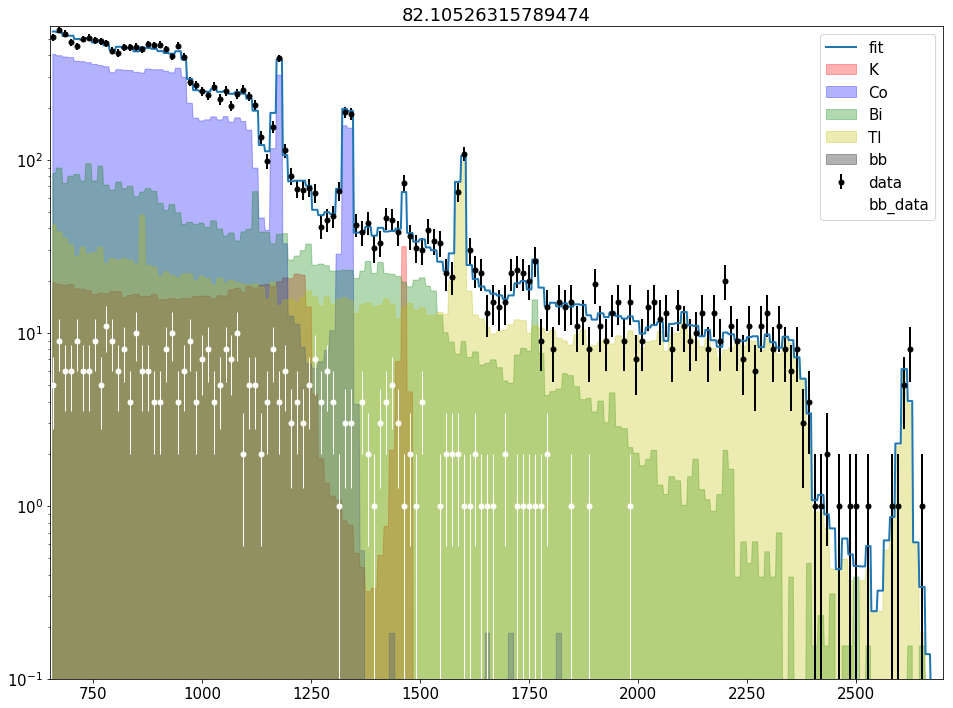

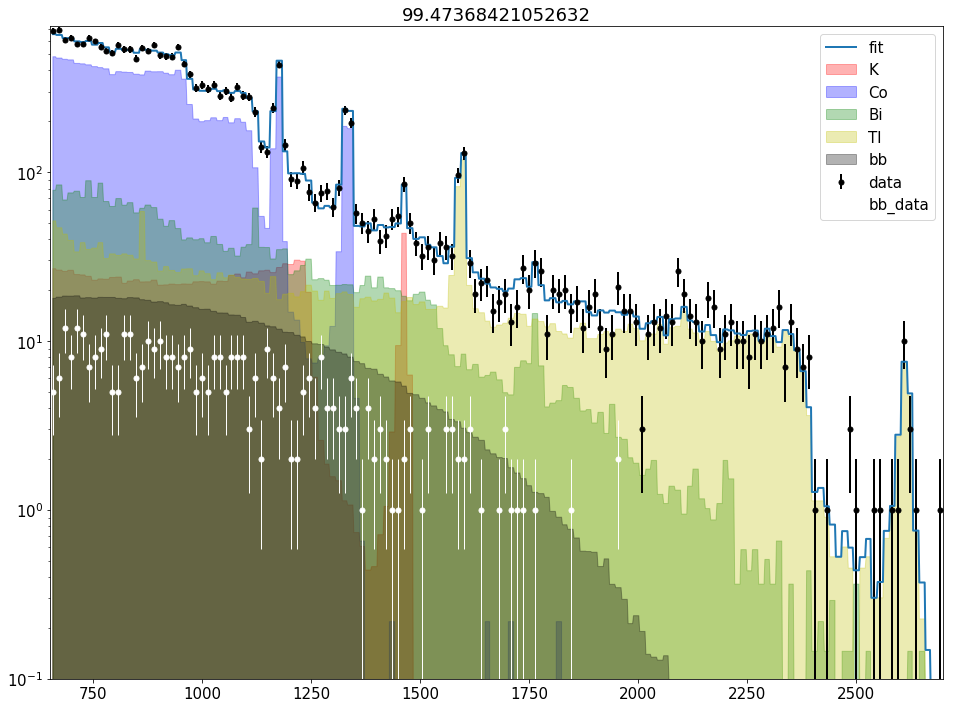

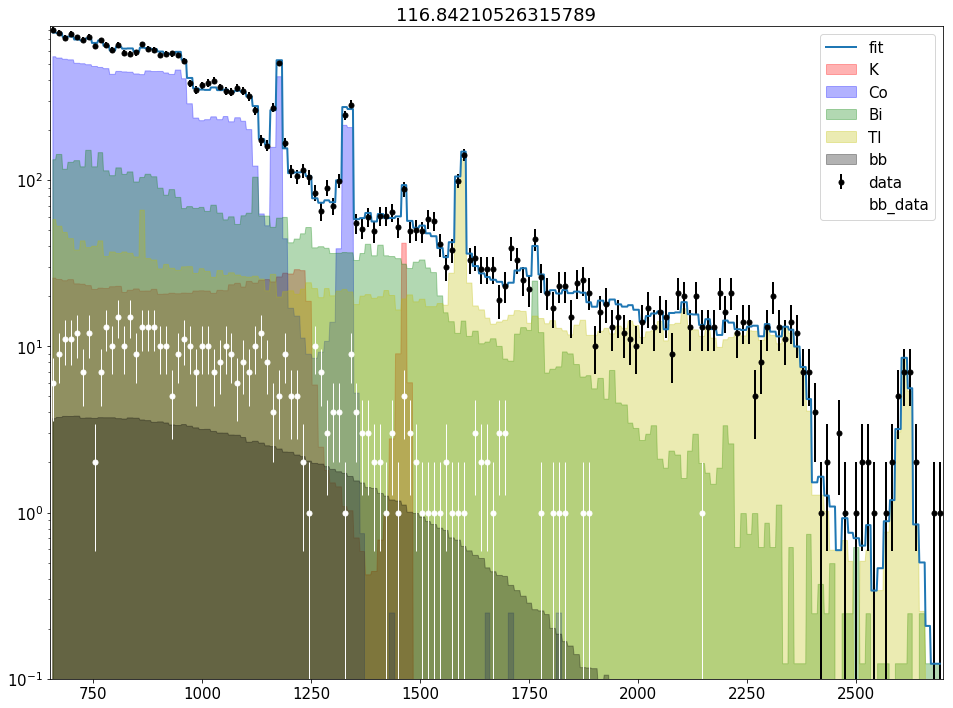

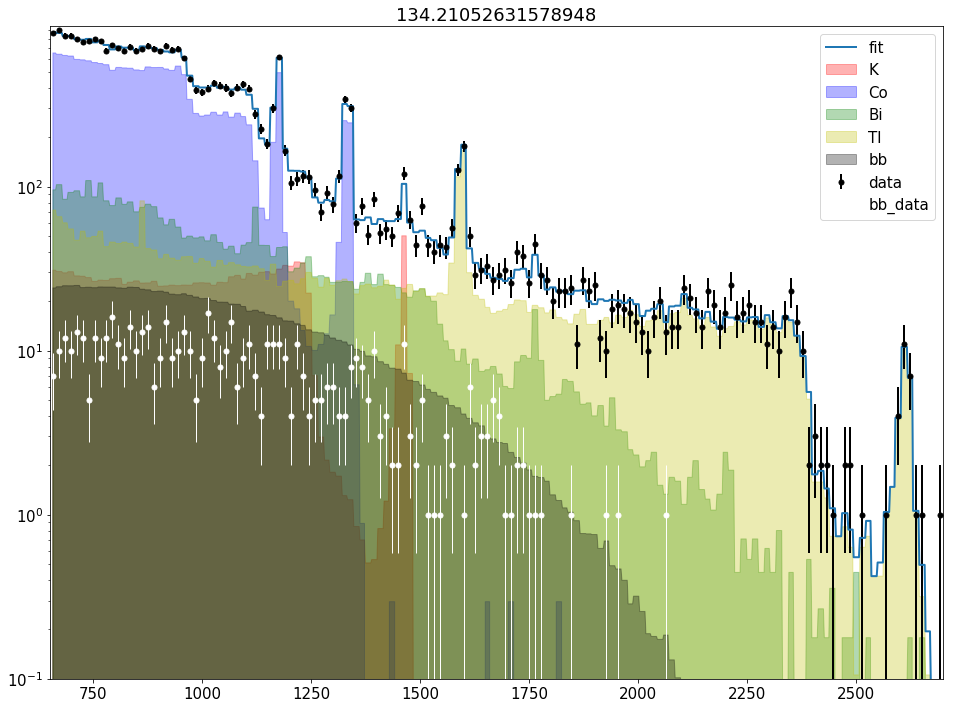

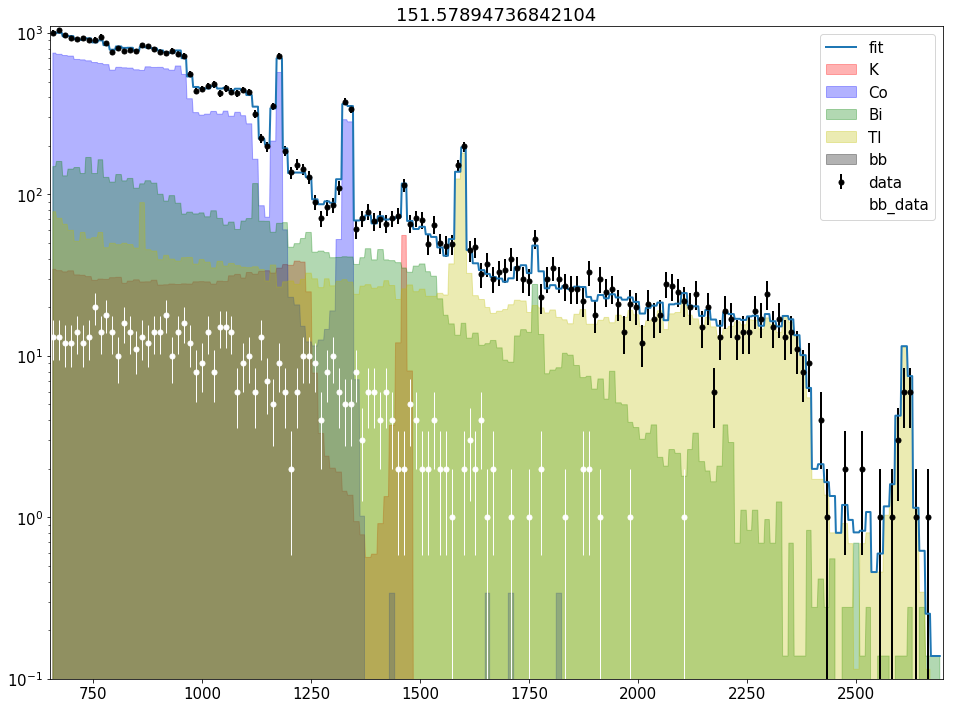

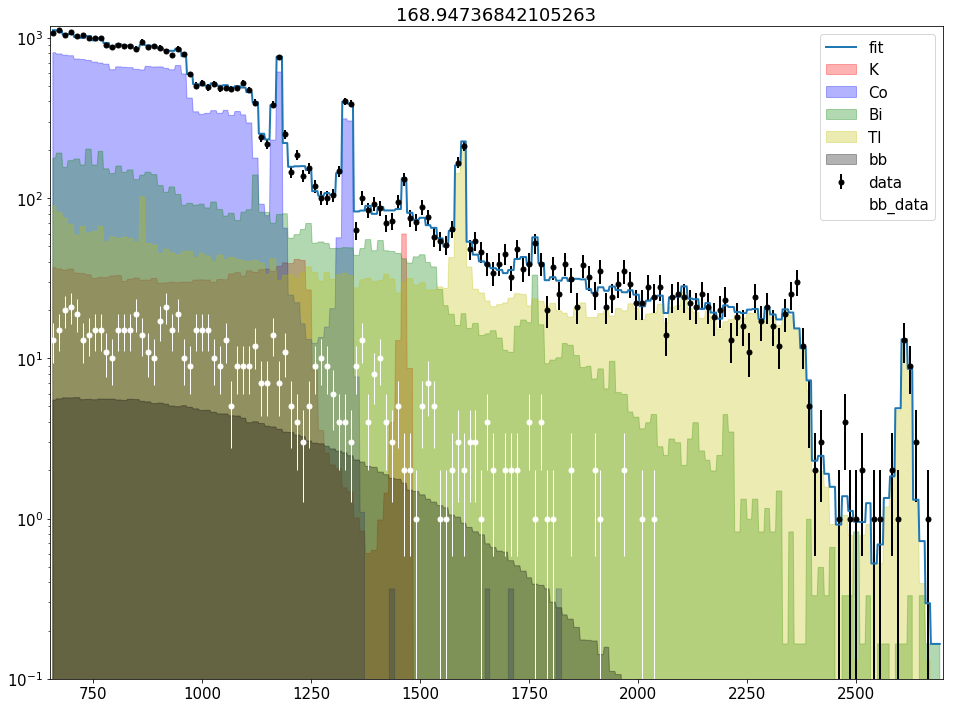

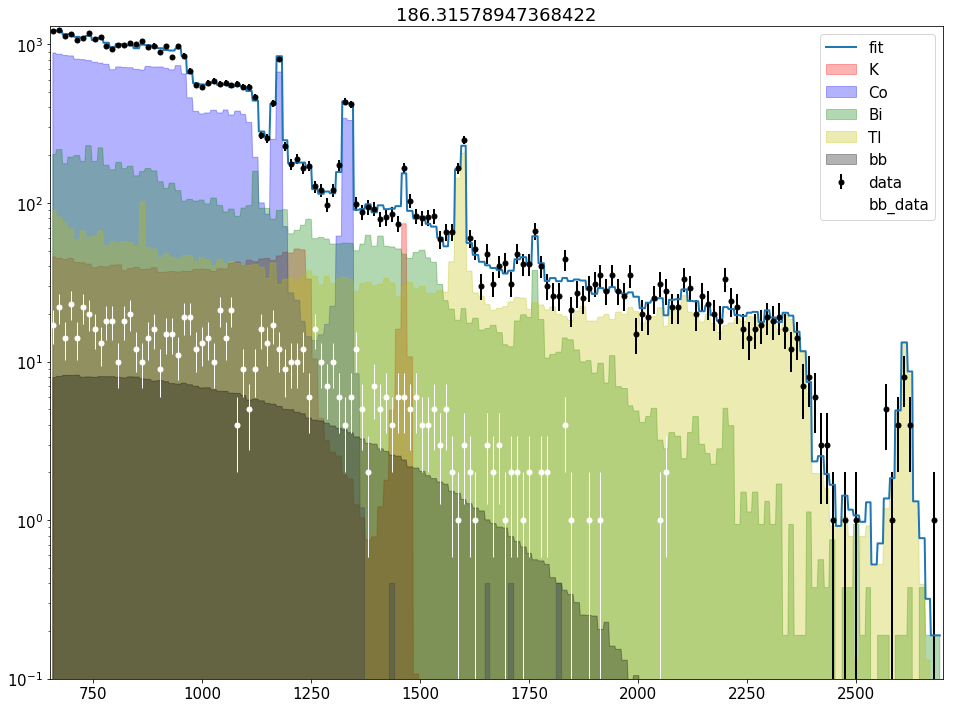

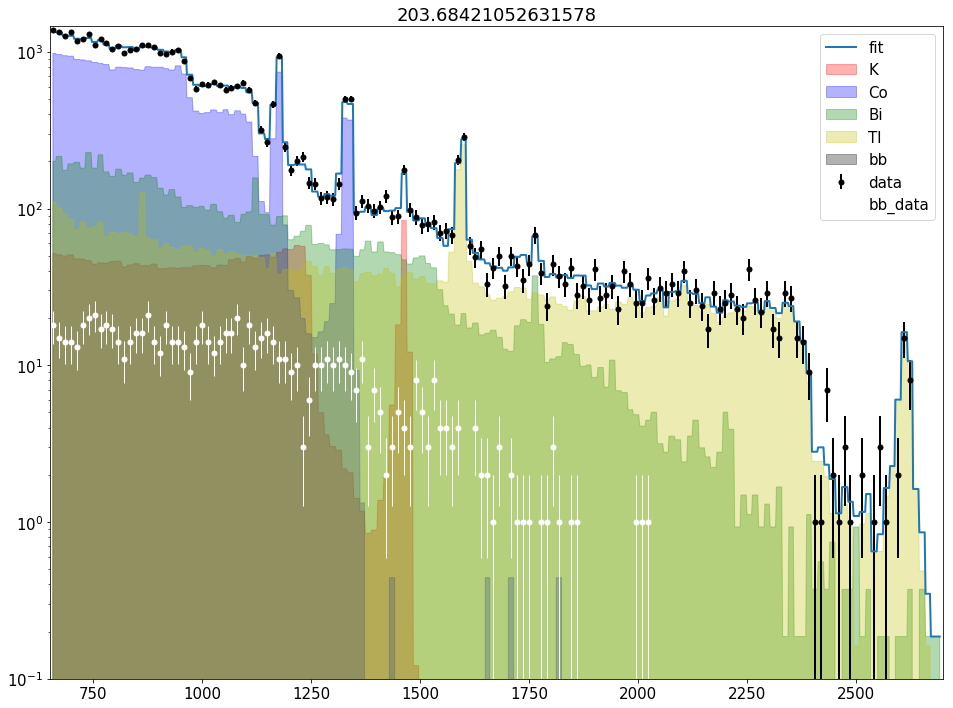

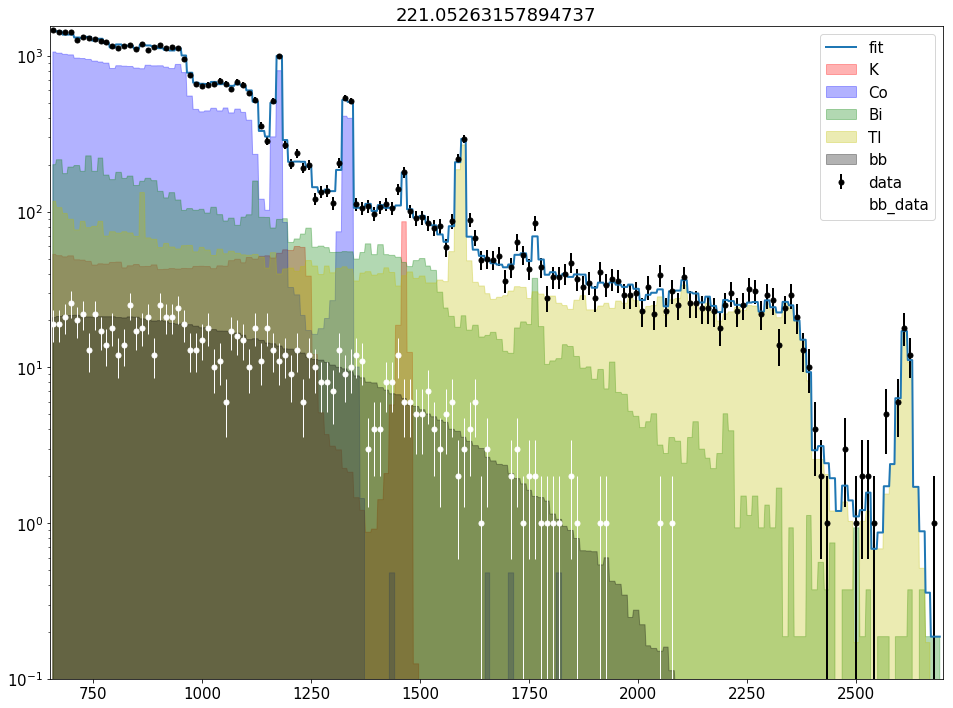

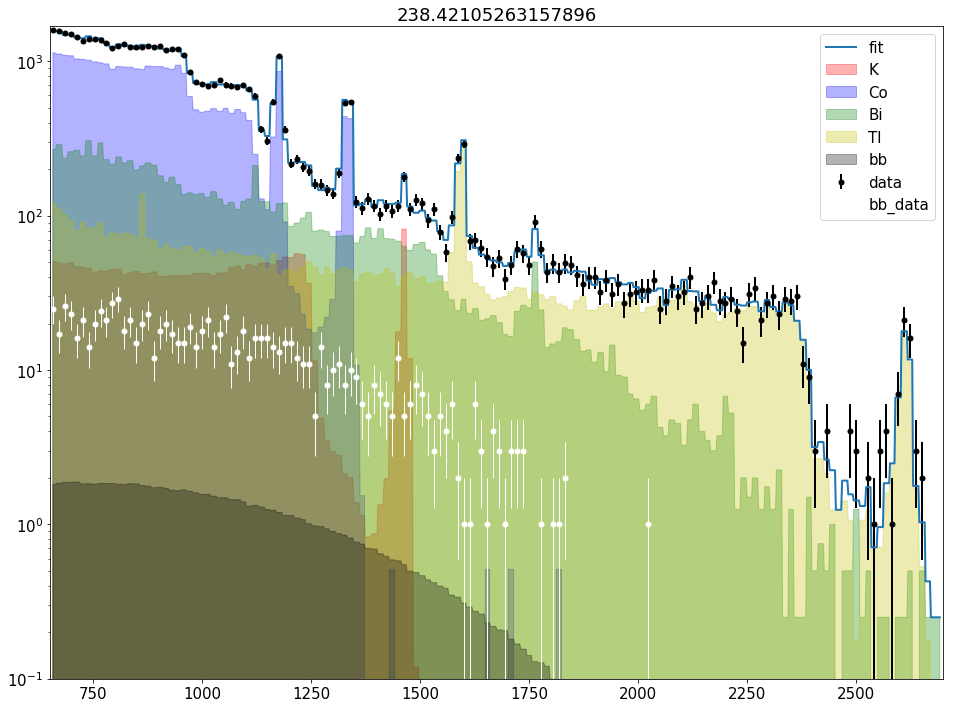

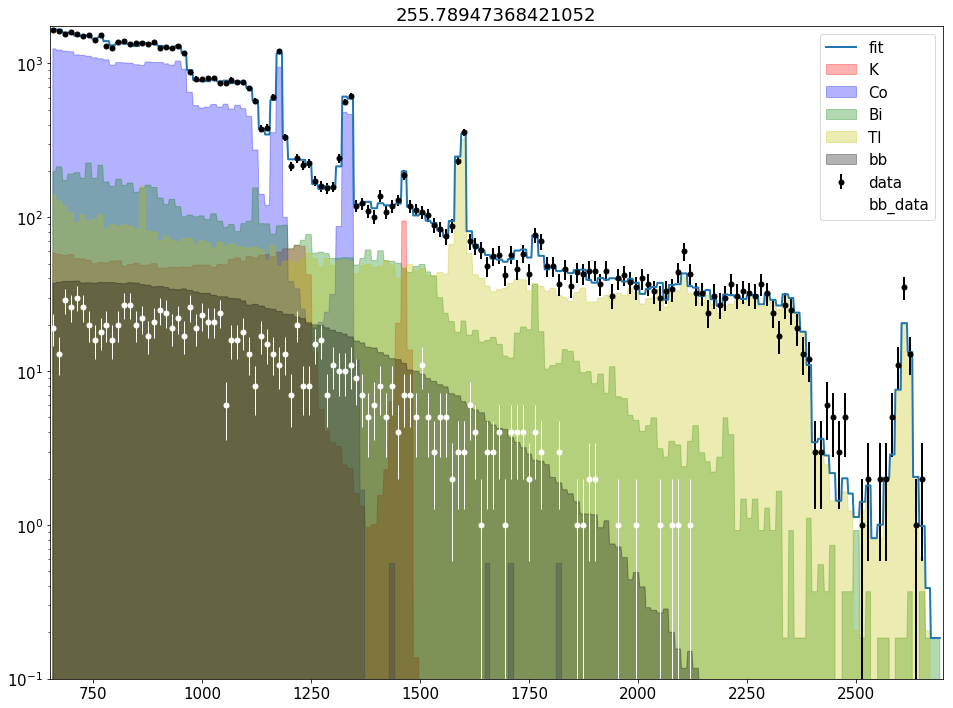

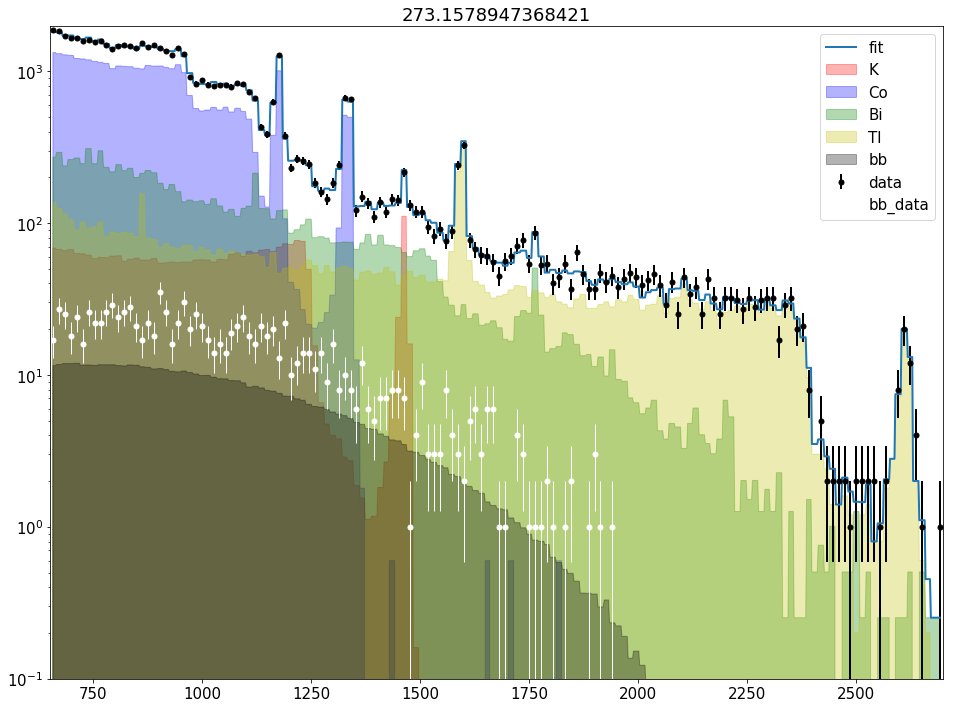

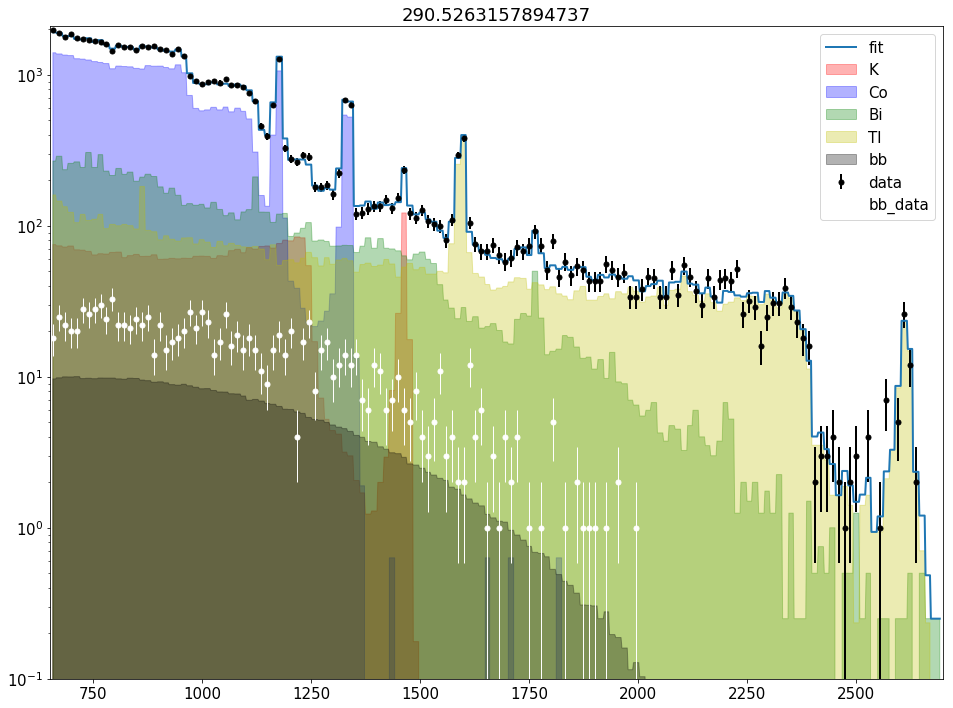

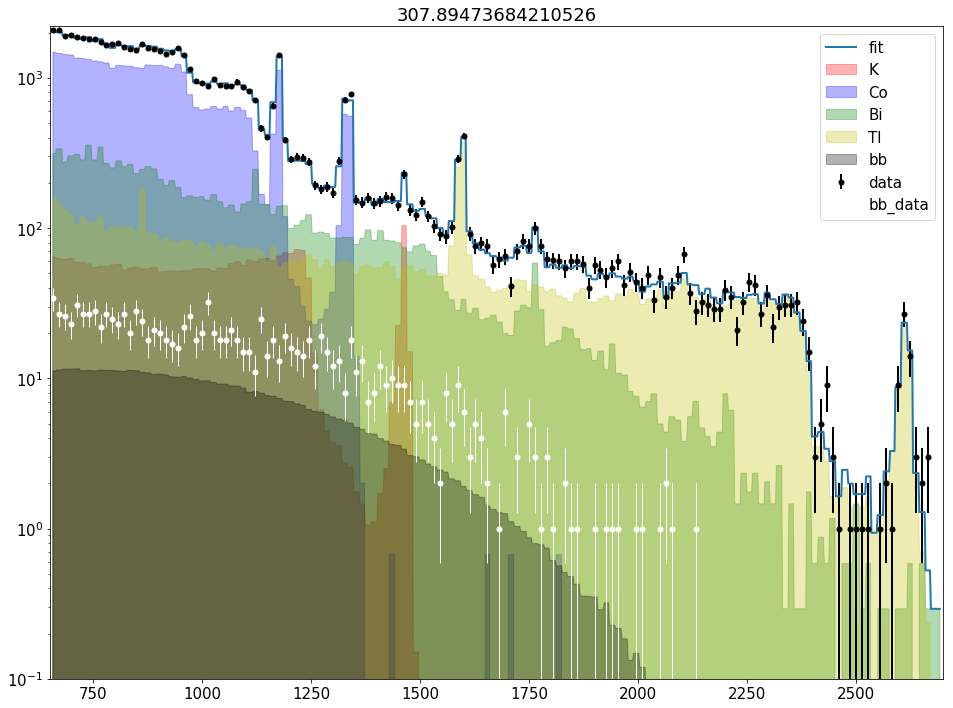

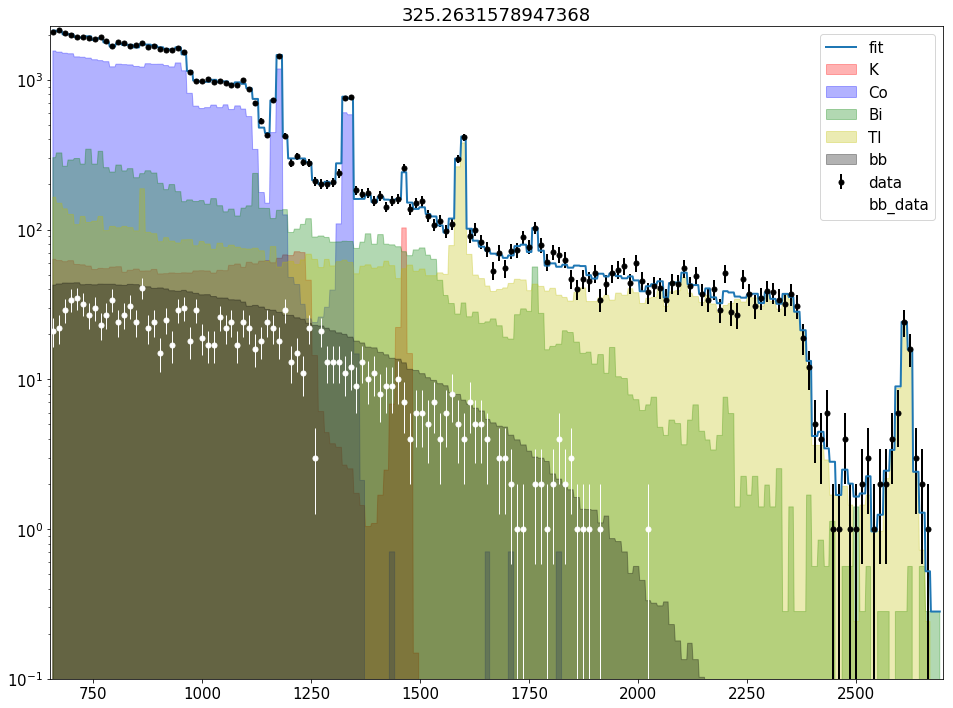

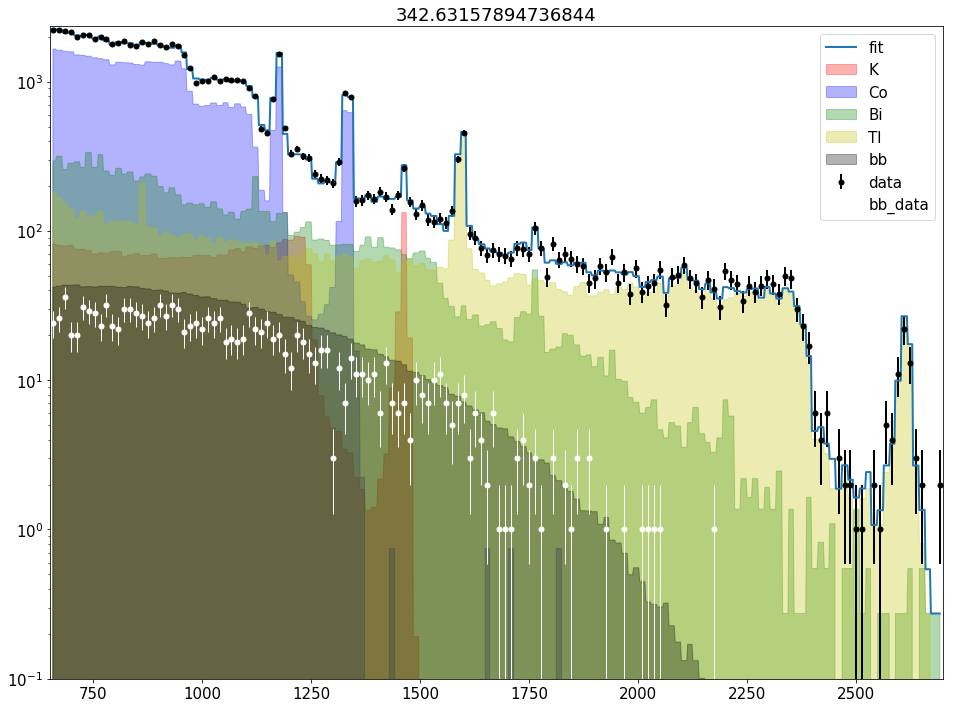

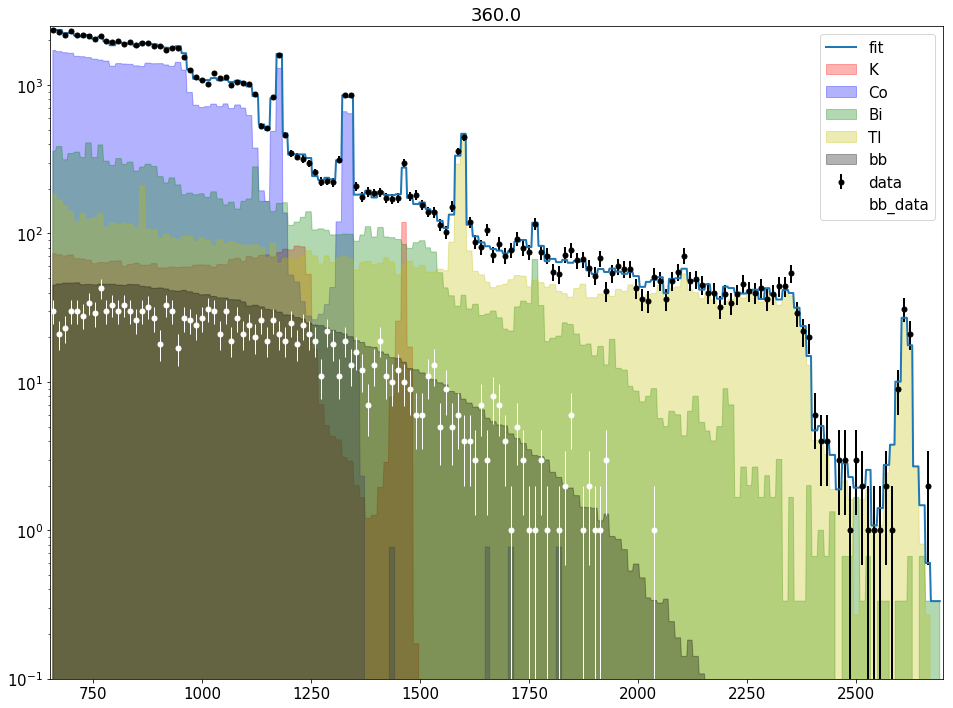

In [128]:
res_list = {}

for days in np.linspace(30, 360, 20):
    
    n_exp = {}
    n_exp['K']  = n_pau['K']  * days * N_K  / (expo_bkg * 365.24)
    n_exp['Co'] = n_pau['Co'] * days * N_Co / (expo_bkg * 365.24)
    n_exp['Bi'] = n_pau['Bi'] * days * N_Bi / (expo_bkg * 365.24)
    n_exp['Tl'] = n_pau['Tl'] * days * N_Tl / (expo_bkg * 365.24)
    n_exp['bb'] = days * N_bb / (expo_bb  * 365.24)
    
    total_data = []
    
    for isotope in isotopes:
        iso_e = np.random.choice(mc_pdfs_noreg[isotope].energy, int(np.random.poisson(n_exp[isotope])))
        total_data.append(iso_e)
    total_bb = np.random.choice(table_data_s.energy, int(np.random.poisson(n_exp['bb'])))
    total_data.append(total_bb)
    total_data = np.concatenate(total_data)
    h_total_e  = hist(total_data, nbinE, minE, maxE)
    h_total_bb = hist(total_bb  , nbinE, minE, maxE)

    
    N_0 = np.array([n_exp[key] for key in n_exp.keys()])
    totals = {'E': h_total_e}
    ratios = np.ones_like(N_0)
    bounds = [[0,2]]*len(N_0)
    fit = Fit(x_dict, totals, pdfs,N_0)
    
    res_ll = fit.FitLLM(ratios,tol=1e-12,options={"maxiter":10000,'ftol':1e-12}, bounds=bounds)
    
    res_list[days] = res_ll
    
    
    #plotting
    plt.figure()
    factors   = res_ll.x * N_0
    Ep = np.linspace(totals['E'].bins[0],totals['E'].bins[-1],1000)
    pdfs_plot = {'E':[]}
    interpol = 'nearest'
    pdfs_plot['E'] = [PDF(h_, factor=factors[i], 
                          interpolation=interpol) for h_, i in zip(histograms['E']+[h_total_e_s], 
                                                                   range(len(N_0)))]

    y_e = [pdf.pdf(Ep) for pdf in pdfs_plot['E']] 
    fittotal_e = np.sum(y_e, axis=0)
    K_e  = y_e[0] 
    Co_e = y_e[1]
    Bi_e = y_e[2]
    Tl_e = y_e[3]
    bb_e = y_e[4]
    
    plt.errorbar(totals['E'].bins, totals['E'].hist, yerr=np.sqrt(totals['E'].hist),
                 marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')
    
    plt.errorbar(totals['E'].bins, h_total_bb.hist, yerr=np.sqrt(h_total_bb.hist),
                 marker='.', markersize=10, elinewidth=1, linewidth=0,label='bb_data',color='w')

    plt.plot(Ep, fittotal_e, label='fit', linewidth=2,)

    alfa = 0.3
    plt.fill_between(Ep, 0 , K_e  , label='K'  ,alpha=alfa,color='r')
    plt.fill_between(Ep, 0 , Co_e , label='Co' ,alpha=alfa,color='b')
    plt.fill_between(Ep, 0 , Bi_e , label='Bi' ,alpha=alfa,color='g')
    plt.fill_between(Ep, 0 , Tl_e , label='Tl' ,alpha=alfa,color='y')
    plt.fill_between(Ep, 0 , bb_e , label='bb' ,alpha=alfa,color='k')

    plt.xlim(minE, maxE)
    plt.ylim(   0.1, np.max(h_total_e.hist)*1.05)
    plt.legend()
    plt.yscale('log')
    plt.title(str(days))